#  Animal Image Classifier with Auto Split (MobileNetV2)

In [1]:
# 1. Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore")


In [2]:
# 2. Dataset Path
dataset_dir = "dataset"  # contains all 15 class folders directly

In [3]:
# 3. Parameters
img_size = (224, 224)
batch_size = 32
val_split = 0.2
num_classes = 15
epochs = 20

In [4]:
# 4. Data Generators
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=val_split,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)
train_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 1561 images belonging to 15 classes.
Found 383 images belonging to 15 classes.


In [5]:
# 5. Model Definition
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# 6. Callbacks
checkpoint_cb = ModelCheckpoint("mobilenetv2_best.h5", save_best_only=True, monitor="val_accuracy", mode="max")
earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)
callbacks=[checkpoint_cb, earlystop_cb]

In [7]:
# 7. Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.4953 - loss: 1.7902

49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 815ms/step - accuracy: 0.4992 - loss: 1.7770 - val_accuracy: 0.8381 - val_loss: 0.5361
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9118 - loss: 0.3328

49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 803ms/step - accuracy: 0.9119 - loss: 0.3320 - val_accuracy: 0.8930 - val_loss: 0.3322
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 795ms/step - accuracy: 0.9451 - loss: 0.2065 - val_accuracy: 0.8642 - val_loss: 0.3770
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 799ms/step - accuracy: 0.9608 - loss: 0.1535 - val_accuracy: 0.8903 - val_loss: 0.2998
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9633 - loss: 0.1373

49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 806ms/step - accuracy: 0.9633 - loss: 0.1369 - val_accuracy: 0.9086 - val_loss: 0.2728
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 47s 967ms/step - accuracy: 0.9760 - loss: 0.0968 - val_accuracy: 0.8773 - val_loss: 0.3712
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 48s 975ms/step - accuracy: 0.9921 - loss: 0.0514 - val_accuracy: 0.8982 - val_loss: 0.3214
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 784ms/step - accuracy: 0.9899 - loss: 0.0500 - val_accuracy: 0.9034 - val_loss: 0.3161
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 810ms/step - accuracy: 0.9891 - loss: 0.0428 - val_accuracy: 0.9034 - val_loss: 0.3322
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 851ms/step - accuracy: 0.9928 - loss: 0.0381 - val_accuracy: 0.8851 - val_loss: 0.3710


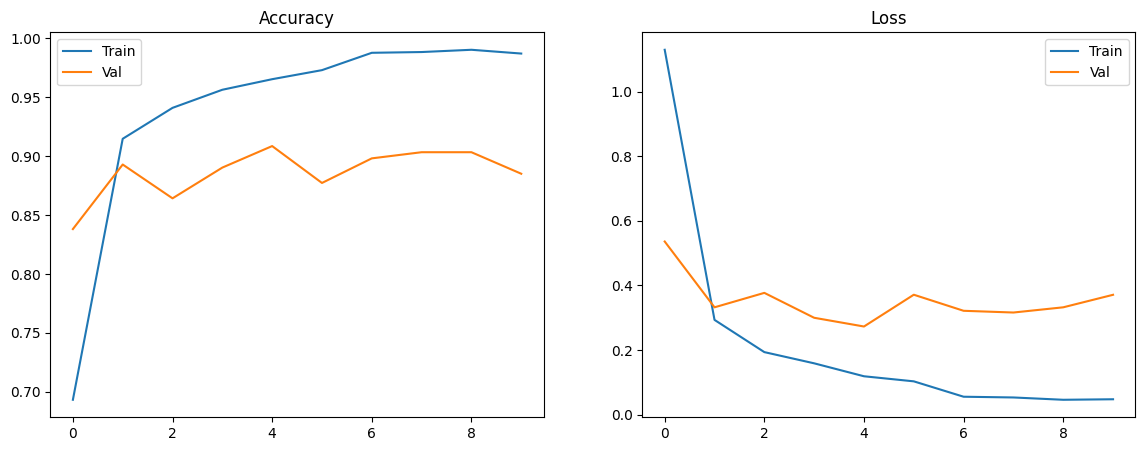

In [8]:
# 8. Plot Accuracy & Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

In [9]:
# 9. Confusion Matrix & Report
val_gen.reset()
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 888ms/step


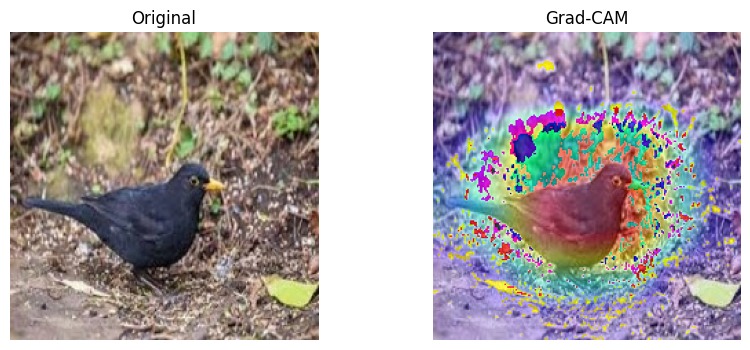

In [10]:
# 10. Grad-CAM Visualization
def get_img_array(img_path, size):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = preprocess_input(array)
    return np.expand_dims(array, axis=0), img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Run Grad-CAM on any image
test_img_path = "dataset/Bird/Bird_29.jpeg"  # replace with real path
img_array, original_img = get_img_array(test_img_path, img_size)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1")
display_gradcam(test_img_path, heatmap)



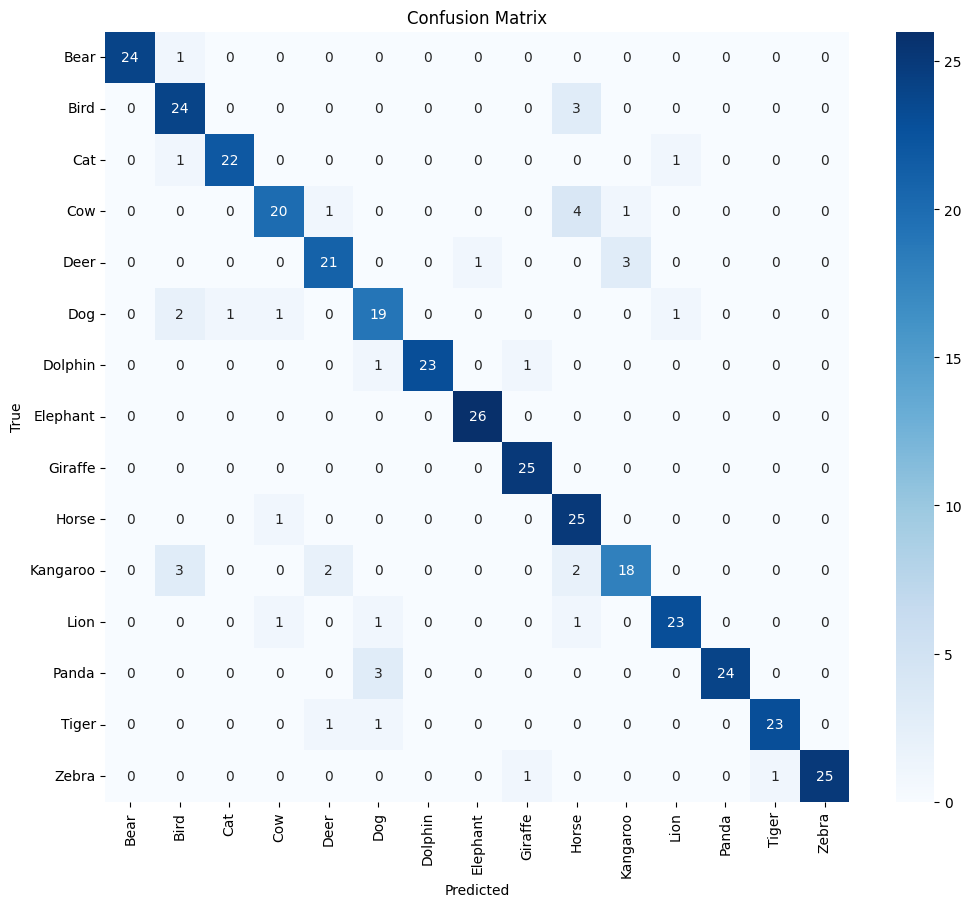

In [11]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [12]:
# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

        Bear       1.00      0.96      0.98        25
        Bird       0.77      0.89      0.83        27
         Cat       0.96      0.92      0.94        24
         Cow       0.87      0.77      0.82        26
        Deer       0.84      0.84      0.84        25
         Dog       0.76      0.79      0.78        24
     Dolphin       1.00      0.92      0.96        25
    Elephant       0.96      1.00      0.98        26
     Giraffe       0.93      1.00      0.96        25
       Horse       0.71      0.96      0.82        26
    Kangaroo       0.82      0.72      0.77        25
        Lion       0.92      0.88      0.90        26
       Panda       1.00      0.89      0.94        27
       Tiger       0.96      0.92      0.94        25
       Zebra       1.00      0.93      0.96        27

    accuracy                           0.89       383
   macro avg       0.90      0.89      0.89       383
weighted avg       0.90   

In [13]:
# Unfreeze the top layers of MobileNetV2 for fine-tuning
base_model.trainable = True

# Freeze all layers except the last 30
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [14]:
# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
# Fine-tune the model
fine_tune_epochs = 10

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=fine_tune_epochs,
    callbacks=callbacks  # Use existing early stopping and checkpoint
)


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 54s 957ms/step - accuracy: 0.8822 - loss: 0.3710 - val_accuracy: 0.8903 - val_loss: 0.3149
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 910ms/step - accuracy: 0.9518 - loss: 0.1694 - val_accuracy: 0.9008 - val_loss: 0.2876
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 910ms/step - accuracy: 0.9711 - loss: 0.1465 - val_accuracy: 0.9034 - val_loss: 0.2632
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 911ms/step - accuracy: 0.9606 - loss: 0.1602 - val_accuracy: 0.9060 - val_loss: 0.2608
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 903ms/step - accuracy: 0.9658 - loss: 0.1263 - val_accuracy: 0.9008 - val_loss: 0.3091
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.9787 - loss: 0.0982

49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 908ms/step - accuracy: 0.9788 - loss: 0.0982 - val_accuracy: 0.9295 - val_loss: 0.2120
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 902ms/step - accuracy: 0.9731 - loss: 0.1020 - val_accuracy: 0.9008 - val_loss: 0.2909
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 907ms/step - accuracy: 0.9801 - loss: 0.0829 - val_accuracy: 0.9060 - val_loss: 0.2696
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 904ms/step - accuracy: 0.9838 - loss: 0.0759 - val_accuracy: 0.9112 - val_loss: 0.2731
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 906ms/step - accuracy: 0.9823 - loss: 0.0849 - val_accuracy: 0.9112 - val_loss: 0.2479


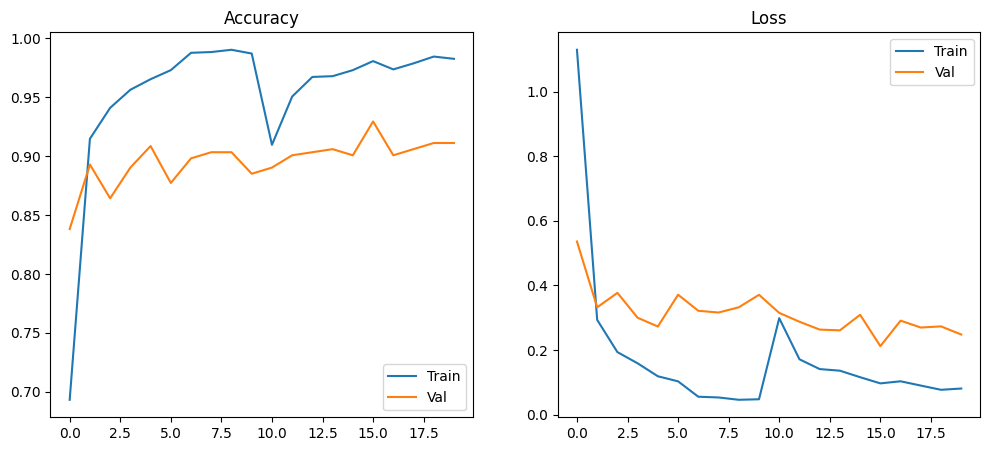

In [16]:
# Combine and plot total training history
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train')
plt.plot(epochs_range, val_acc, label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train')
plt.plot(epochs_range, val_loss, label='Val')
plt.title('Loss')
plt.legend()
plt.show()
